In [224]:
import pandas as pd

# Cleanup and import data

In [255]:
bitcoin = pd.read_csv('datasets/coin_Bitcoin.csv')
bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])
bitcoin.set_index('Date', inplace=True)
bitcoin.index.freq = 'D'
bitcoin.head()

,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,,
2013-04-29 23:59:59,1,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30 23:59:59,2,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01 23:59:59,3,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02 23:59:59,4,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03 23:59:59,5,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


# Plot the data

<Axes: xlabel='Date'>

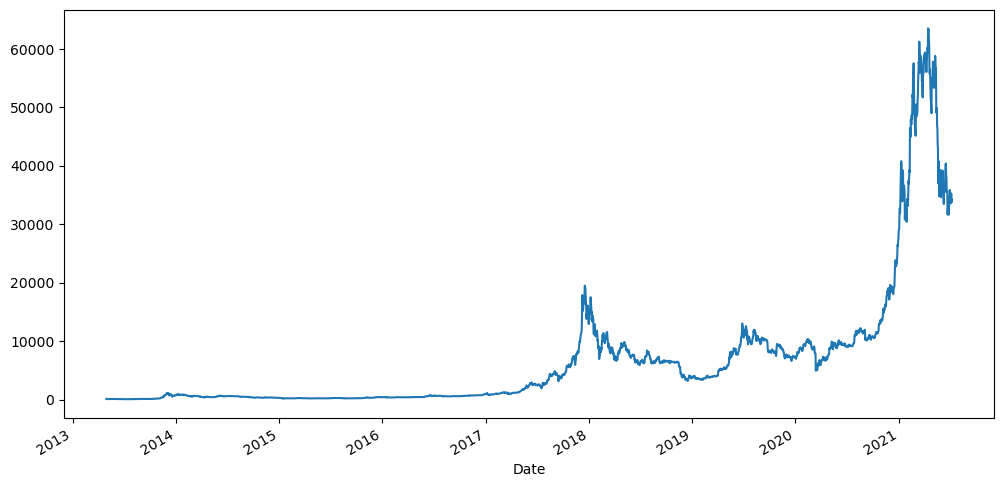

In [226]:
bitcoin['Close'].plot(figsize=(12, 6))

# Examine autocorrelation and partial autocorrelation

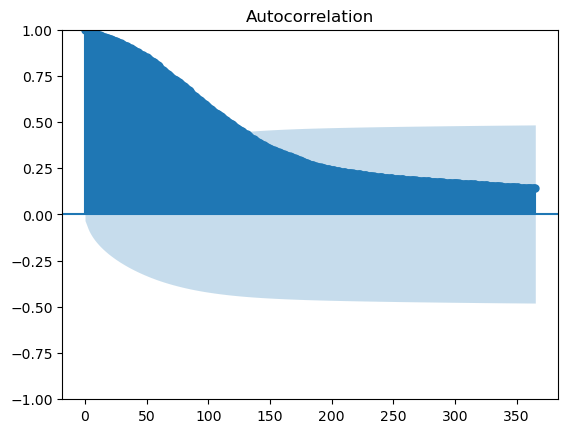

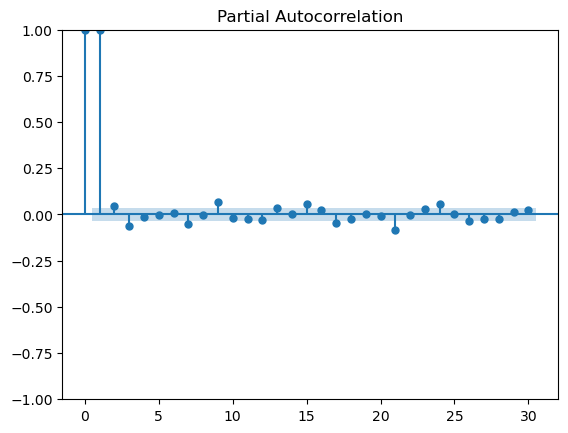

In [227]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(bitcoin['Close'], lags=365)
pacf = plot_pacf(bitcoin['Close'], lags=30)

# Check if the series is stationary

In [228]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(bitcoin['Close'])

p_value = result[1]

if p_value < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

The time series is not stationary.


Let's difference the series and see if it's stationary after differencing.

In [229]:
differenced_series = bitcoin['Close'].diff().dropna()

result = adfuller(differenced_series)

p_value = result[1]

if p_value < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

The time series is stationary.


The series is stationary after differencing, let's plot it to see how it looks like.

<Axes: xlabel='Date'>

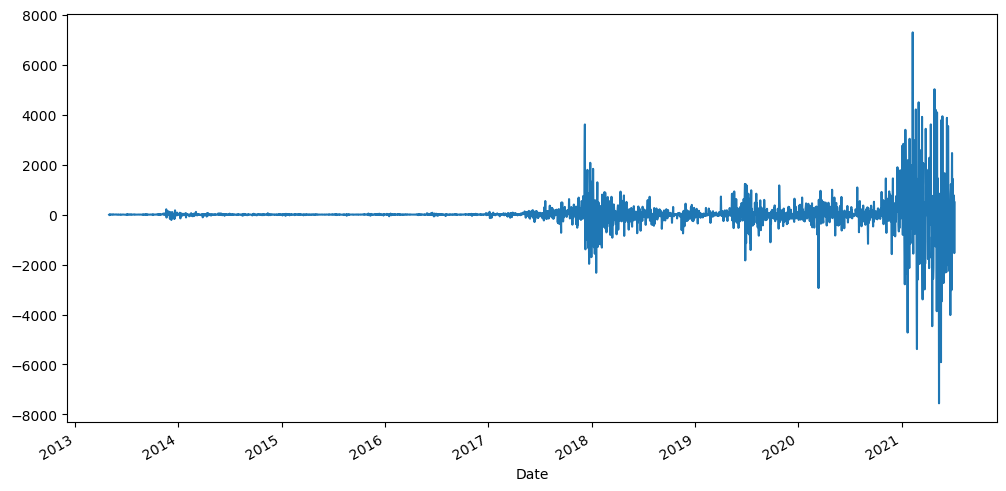

In [230]:
differenced_series.plot(figsize=(12, 6))

# Apply seasonal decomposition to the daily data

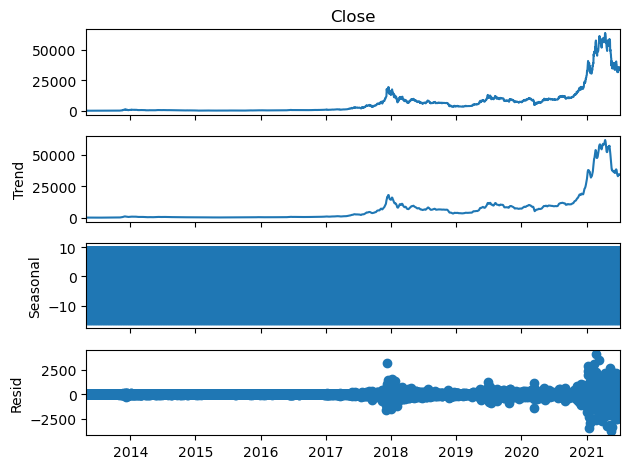

In [231]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(bitcoin['Close'], model='add').plot();

Daily data contains too much noise, no distinct seasonal trend can be extracted, let's try the monthly-averaged data instead. Very high residual values post-2021 could make forcasting for this period a very difficult task.

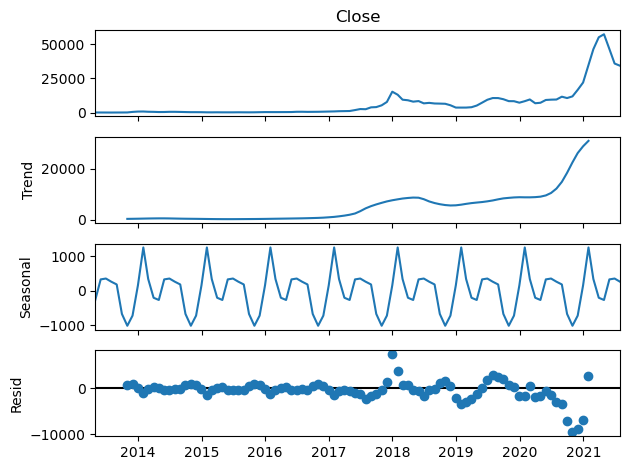

In [232]:
bitcoin_monthly = bitcoin['Close'].resample('M').mean()
seasonal_decompose(bitcoin_monthly, model='add').plot();

Monthly data exhibits clear yearly seasonality. 

# SARIMA monthly forecasting

Let's try to fit a SARIMA model to the series. The fact that the series is non-stationary is not an issue, as the auto_arima function will do the differencing for us. 

In [233]:
from pmdarima import auto_arima

model = auto_arima(bitcoin_monthly, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1802.194, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1856.782, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1811.767, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1803.904, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1856.269, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1799.448, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1800.193, Time=0.04 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=1800.035, Time=0.31 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1801.350, Time=0.09 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=1804.475, Time=0.16 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=1798.509, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1797.617, Time=0.07 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=1799.734, Time=0.06 sec
 ARIMA(2,1,1)(1,0,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  100
Model:             SARIMAX(3, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -886.198
Date:                              Tue, 18 Jun 2024   AIC                           1792.397
Time:                                      16:46:29   BIC                           1818.348
Sample:                                  04-30-2013   HQIC                          1802.896
                                       - 07-31-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    205.8023    182.187      1.130      0.259    -151.277     562.881
ar.L1          0.7456      0.262      2.846      0.004       0.232       1.259
ar.L2         -0.2008      0.301     -0.667      0.505      -0.791       0.389
ar.L3         -0.4768      0.223     -2.139      0.032      -0.914      -0.040
ma.L1          0.0842      0.273      0.308      0.758      -0.451       0.619
ma.L2         -0.0720      0.208     -0.346      0.730      -0.480       0.336
ma.L3          0.5071      0.226      2.242      0.025       0.064       0.950
ar.S.L12       0.4784      0.296      1.615      0.106      -0.102       1.059
ma.S.L12      -0.8315      0.266     -3.128      0.002      -1.352      -0.311
sigma2      3.181e+06   4.54e+05      7.006      0.000    2.29e+06    4.07e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               265.07
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              56.98   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.52e+14. Standard errors may be unstable.
"""

Let's try making a forecast for the last 6 months.

In [234]:
arima_forecast_length = 6

In [235]:
train_arima = bitcoin_monthly.iloc[:-arima_forecast_length]
test_arima = bitcoin_monthly.iloc[-arima_forecast_length:]

In [236]:
model.fit(train_arima)
fitted_values = model.predict_in_sample()
forecast = model.predict(n_periods=arima_forecast_length)

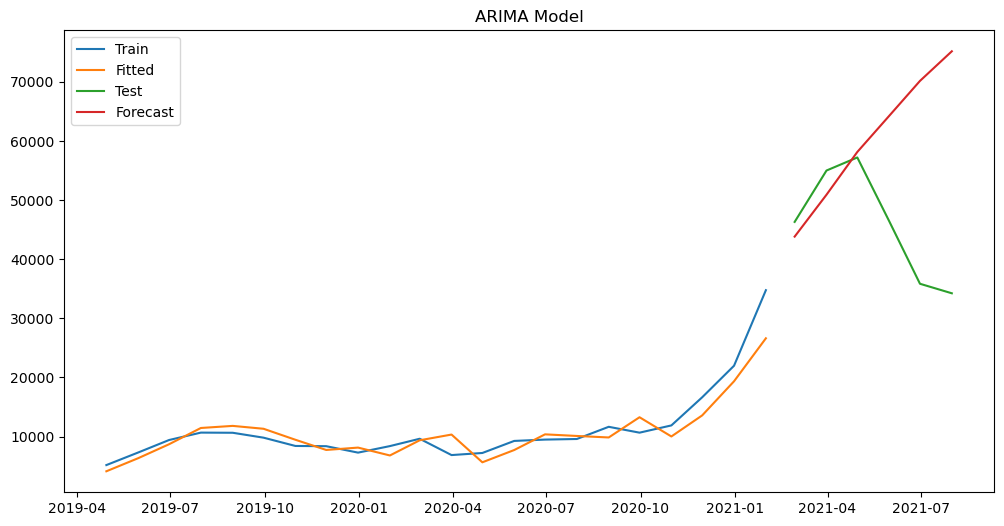

In [237]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title('ARIMA Model')
plt.plot(train_arima.index[72:], train_arima[72:], label='Train')
plt.plot(train_arima.index[72:], fitted_values[72:], label='Fitted')
plt.plot(test_arima.index, test_arima, label='Test')
plt.plot(test_arima.index, forecast, label='Forecast')
plt.legend()
plt.show()

The forecast is poor, the predictions completely contradict the actual values once the trend reverses. High residual values indicated that this could be the case.

Let's try making a forecast where the series is more predictable and the residual values aren't so high. 

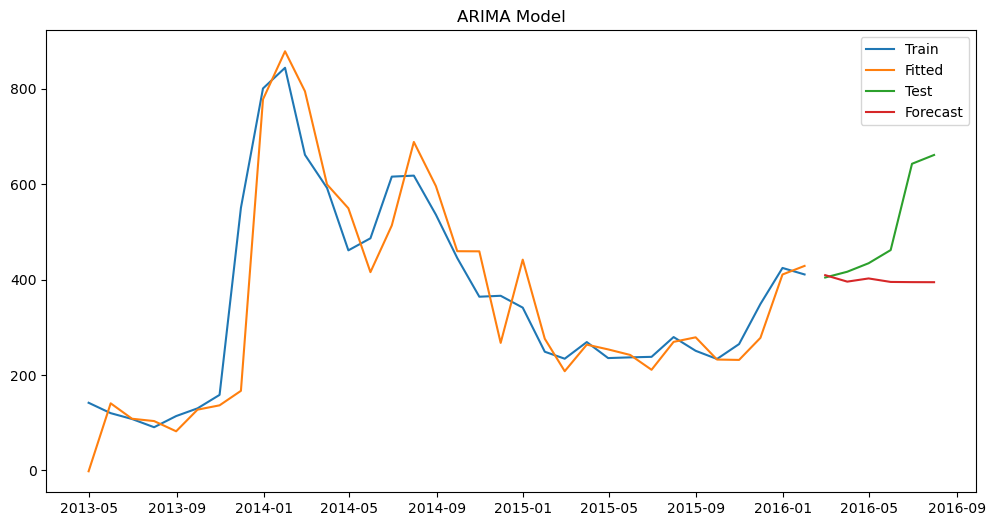

In [238]:
train_arima = bitcoin_monthly.loc[:'2016-01-31']
test_arima = bitcoin_monthly.loc['2016-02-01':'2016-07-31'] 

model.fit(train_arima)

fitted_values = model.predict_in_sample()
forecast = model.predict(n_periods=arima_forecast_length)

plt.figure(figsize=(12, 6))
plt.title('ARIMA Model')
plt.plot(train_arima.index, train_arima, label='Train')
plt.plot(train_arima.index, fitted_values, label='Fitted')
plt.plot(test_arima.index, test_arima, label='Test')
plt.plot(test_arima.index, forecast, label='Forecast')
plt.legend()
plt.show()

The SARIMA model makes poor forecasts for the monthly data, even for the time period, where the residuals are relatively low. 

# Daily forecasting with machine learning regressors

First, we need to create the lagged features and day of week, day of month and day of year features.

In [223]:
lag_count = 30
bitcoin_lagged = bitcoin[['Close']].copy()
for i in range(lag_count,0,-1):
    bitcoin_lagged['t='+str(i)] = bitcoin_lagged['Close'].shift(i)
bitcoin_lagged.dropna(inplace=True)
bitcoin_lagged['weekday'] = bitcoin_lagged.index.weekday
bitcoin_lagged['day_of_month'] = bitcoin_lagged.index.day
bitcoin_lagged['day_of_year'] = bitcoin_lagged.index.dayofyear
bitcoin_lagged.head()

,Close,t=30,t=29,t=28,t=27,t=26,t=25,t=24,t=23,t=22,...,t=7,t=6,t=5,t=4,t=3,t=2,t=1,weekday,day_of_month,day_of_year
Date,,,,,,,,,,,,,,,,,,,,,
2013-06-12 23:59:59,108.150002,117.980003,111.500000,114.220001,118.760002,123.014999,123.498001,121.989998,122.000000,122.879997,...,121.650002,118.000000,111.500000,108.300003,100.000000,106.349998,108.900002,2,12,163
2013-06-13 23:59:59,104.000000,111.500000,114.220001,118.760002,123.014999,123.498001,121.989998,122.000000,122.879997,123.889000,...,118.000000,111.500000,108.300003,100.000000,106.349998,108.900002,108.150002,3,13,164
2013-06-14 23:59:59,99.978897,114.220001,118.760002,123.014999,123.498001,121.989998,122.000000,122.879997,123.889000,126.699997,...,111.500000,108.300003,100.000000,106.349998,108.900002,108.150002,104.000000,4,14,165
2013-06-15 23:59:59,99.988098,118.760002,123.014999,123.498001,121.989998,122.000000,122.879997,123.889000,126.699997,133.199997,...,108.300003,100.000000,106.349998,108.900002,108.150002,104.000000,99.978897,5,15,166
2013-06-16 23:59:59,99.510002,123.014999,123.498001,121.989998,122.000000,122.879997,123.889000,126.699997,133.199997,131.979996,...,100.000000,106.349998,108.900002,108.150002,104.000000,99.978897,99.988098,6,16,167


Let's try 30-day non-recurrent forecast. 

In [215]:
forecast_length = 30
train = bitcoin_lagged.iloc[:-forecast_length]
test = bitcoin_lagged.iloc[-forecast_length:]

In [216]:
from sklearn.model_selection import train_test_split

X = train.drop('Close', axis=1)
y = train['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

We're going ro use random forest regressor, gradient boosting and xgboost. 

In [144]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
rf_model = grid_search.best_estimator_

print(best_params)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'max_depth': 30, 'n_estimators': 100}


In [145]:
from sklearn.ensemble import GradientBoostingRegressor


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
}

gb = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
gb_model = grid_search.best_estimator_

print(best_params)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


{'max_depth': 10, 'n_estimators': 100}


In [146]:
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.3]
}

xgb_model = XGBRegressor(n_estimators=300, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_percentage_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
xgb_model = grid_search.best_estimator_

print(best_params)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100}


In [152]:
from sklearn.metrics import mean_absolute_percentage_error

print("Random Forest MAPE: ", mean_absolute_percentage_error(y_test, rf_model.predict(X_test))*100)
print("Gradient Boosting MAPE: ", mean_absolute_percentage_error(y_test, gb_model.predict(X_test))*100)
print("XGBoost MAPE: ", mean_absolute_percentage_error(y_test, xgb_model.predict(X_test))*100)

Random Forest MAPE:  3.0288839137155286
Gradient Boosting MAPE:  3.182837128096241
XGBoost MAPE:  3.3632856476607085


In [217]:
def make_predictions(model):
    X_test = test.drop('Close', axis=1)
    y_pred = model.predict(X_test)
    
    return y_pred

In [218]:
def get_naive_forecast():
    return bitcoin['Close'].shift(1).iloc[-forecast_length:]

In [150]:
test_prediction_rfr = make_predictions(rf_model)
test_prediction_gb = make_predictions(gb_model)
test_prediction_xgb = make_predictions(xgb_model)

In [154]:
print(f'Rfr MAPE: {mean_absolute_percentage_error(test["Close"], test_prediction_rfr)*100}')
print(f'GB MAPE: {mean_absolute_percentage_error(test["Close"], test_prediction_gb)*100}')
print(f'XGB MAPE: {mean_absolute_percentage_error(test["Close"], test_prediction_xgb)*100}')

naive_forecast = get_naive_forecast()
print(f'Naive MAPE: {mean_absolute_percentage_error(test["Close"], naive_forecast)*100}')

Rfr MAPE: 4.227508526091659
GB MAPE: 6.112206736325634
XGB MAPE: 4.8799181354945205
Naive MAPE: 3.789446641682695


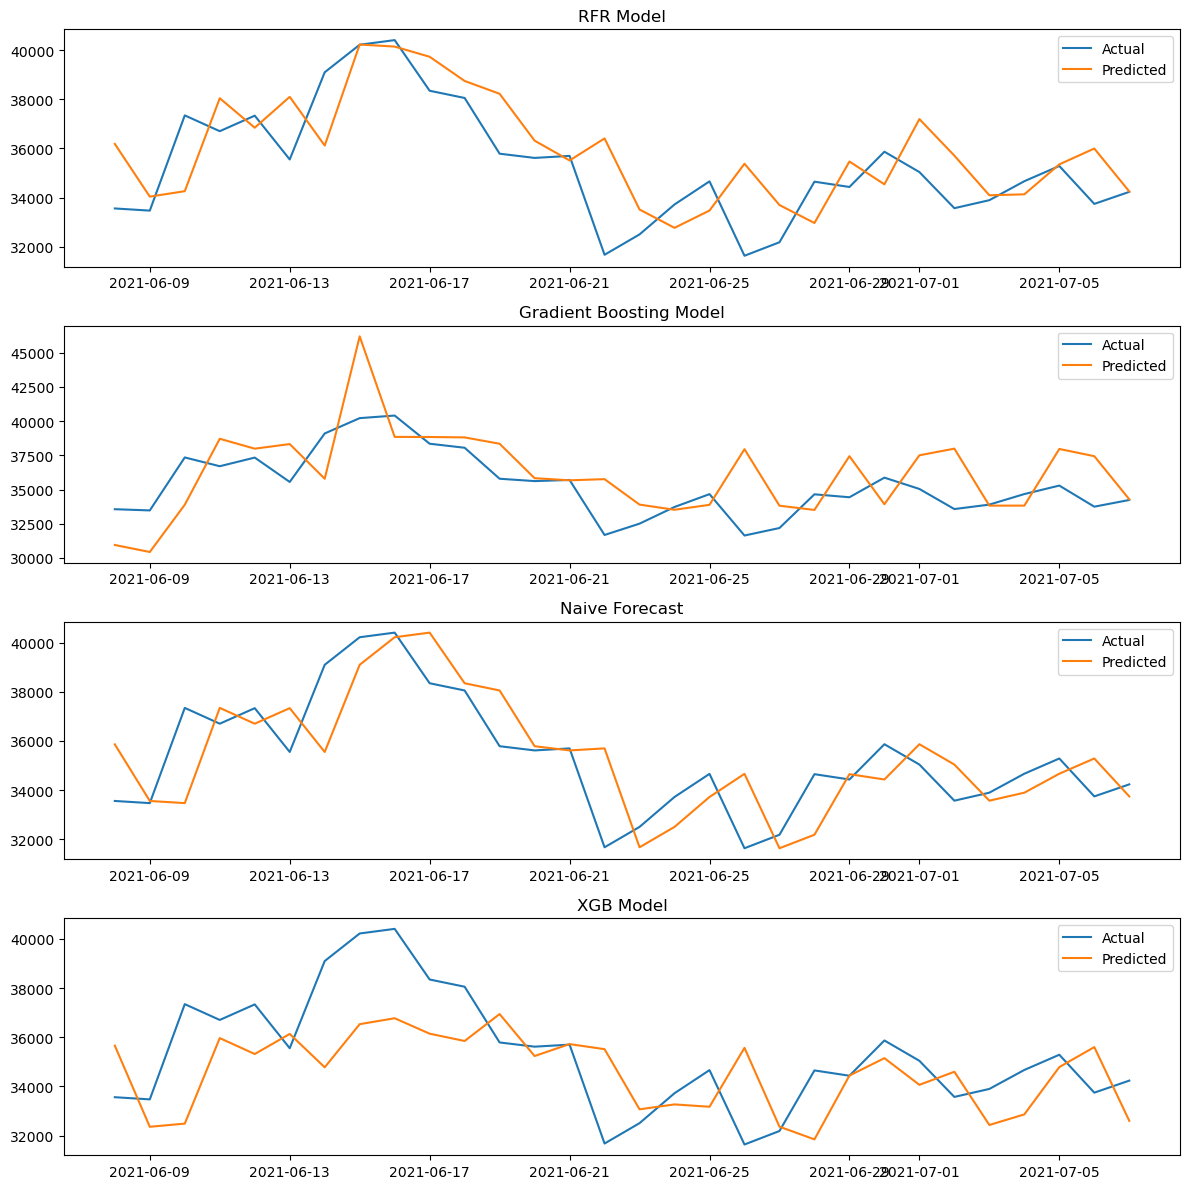

In [155]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, figsize=(12, 12))

axs[0].plot(test.index, test['Close'], label='Actual')
axs[0].plot(test.index, test_prediction_rfr, label='Predicted')
axs[0].set_title('RFR Model')
axs[0].legend()


axs[1].plot(test.index, test['Close'], label='Actual')
axs[1].plot(test.index, test_prediction_gb, label='Predicted')
axs[1].set_title('Gradient Boosting Model')
axs[1].legend()

axs[2].plot(test.index, test['Close'], label='Actual')
axs[2].plot(test.index, naive_forecast, label='Predicted')
axs[2].set_title('Naive Forecast')
axs[2].legend()

axs[3].plot(test.index, test['Close'], label='Actual')
axs[3].plot(test.index, test_prediction_xgb, label='Predicted')
axs[3].set_title('XGB Model')
axs[3].legend()

plt.tight_layout()

plt.show()

Naive forecast is better than the non-recurrent predictions made by the models.

Looking at the plot of the time series, it is evident, that the series post-2017 exhibits different behaviour than the pre-2017. Let's train the models on the post-2017 data only and see if it improves the predictions. 

In [156]:
bitcoin_lagged_post_2017 = bitcoin_lagged.loc['2017-01-31':]

train = bitcoin_lagged_post_2017.iloc[:-forecast_length]
test = bitcoin_lagged_post_2017.iloc[-forecast_length:]

X = train.drop('Close', axis=1)
y = train['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [159]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50],
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_percentage_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
rf_model = grid_search.best_estimator_

print(best_params)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
{'max_depth': 30, 'n_estimators': 400}


The grid search determined that a model with higher number of estimatiors will fit the post-2017 data better, this suggests that data from this point on exhibits more complex patterns. Let's find optimal hyperparameters for the remaining regressors.

In [160]:
param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [20, 30, 40],
}

gb = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_percentage_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
gb_model = grid_search.best_estimator_

print(best_params)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'max_depth': 30, 'n_estimators': 300}


In [161]:
param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [30, 40, 50],
    'learning_rate': [0.01, 0.1, 0.3]
}

xgb_model = XGBRegressor(random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_percentage_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
xgb_model = grid_search.best_estimator_

print(best_params)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 300}


In [162]:
print("Random Forest MAPE: ", mean_absolute_percentage_error(y_test, rf_model.predict(X_test))*100)
print("Gradient Boosting MAPE: ", mean_absolute_percentage_error(y_test, gb_model.predict(X_test))*100)
print("XGBoost MAPE: ", mean_absolute_percentage_error(y_test, xgb_model.predict(X_test))*100)

Random Forest MAPE:  2.9497129639289916
Gradient Boosting MAPE:  3.9531220061690004
XGBoost MAPE:  3.4411700656529076


In [163]:
test_prediction_rfr = make_predictions(rf_model)
test_prediction_gb = make_predictions(gb_model)
test_prediction_xgb = make_predictions(xgb_model)

print(f'Rfr MAPE: {mean_absolute_percentage_error(test["Close"], test_prediction_rfr)*100}')
print(f'GB MAPE: {mean_absolute_percentage_error(test["Close"], test_prediction_gb)*100}')
print(f'XGB MAPE: {mean_absolute_percentage_error(test["Close"], test_prediction_xgb)*100}')

naive_forecast = get_naive_forecast()
print(f'Naive MAPE: {mean_absolute_percentage_error(test["Close"], naive_forecast)*100}')

Rfr MAPE: 4.512758618181671
GB MAPE: 5.936678957974591
XGB MAPE: 5.415214913709397
Naive MAPE: 3.789446641682695


MAPE values are lower, after training the models on the post-2017 data only.

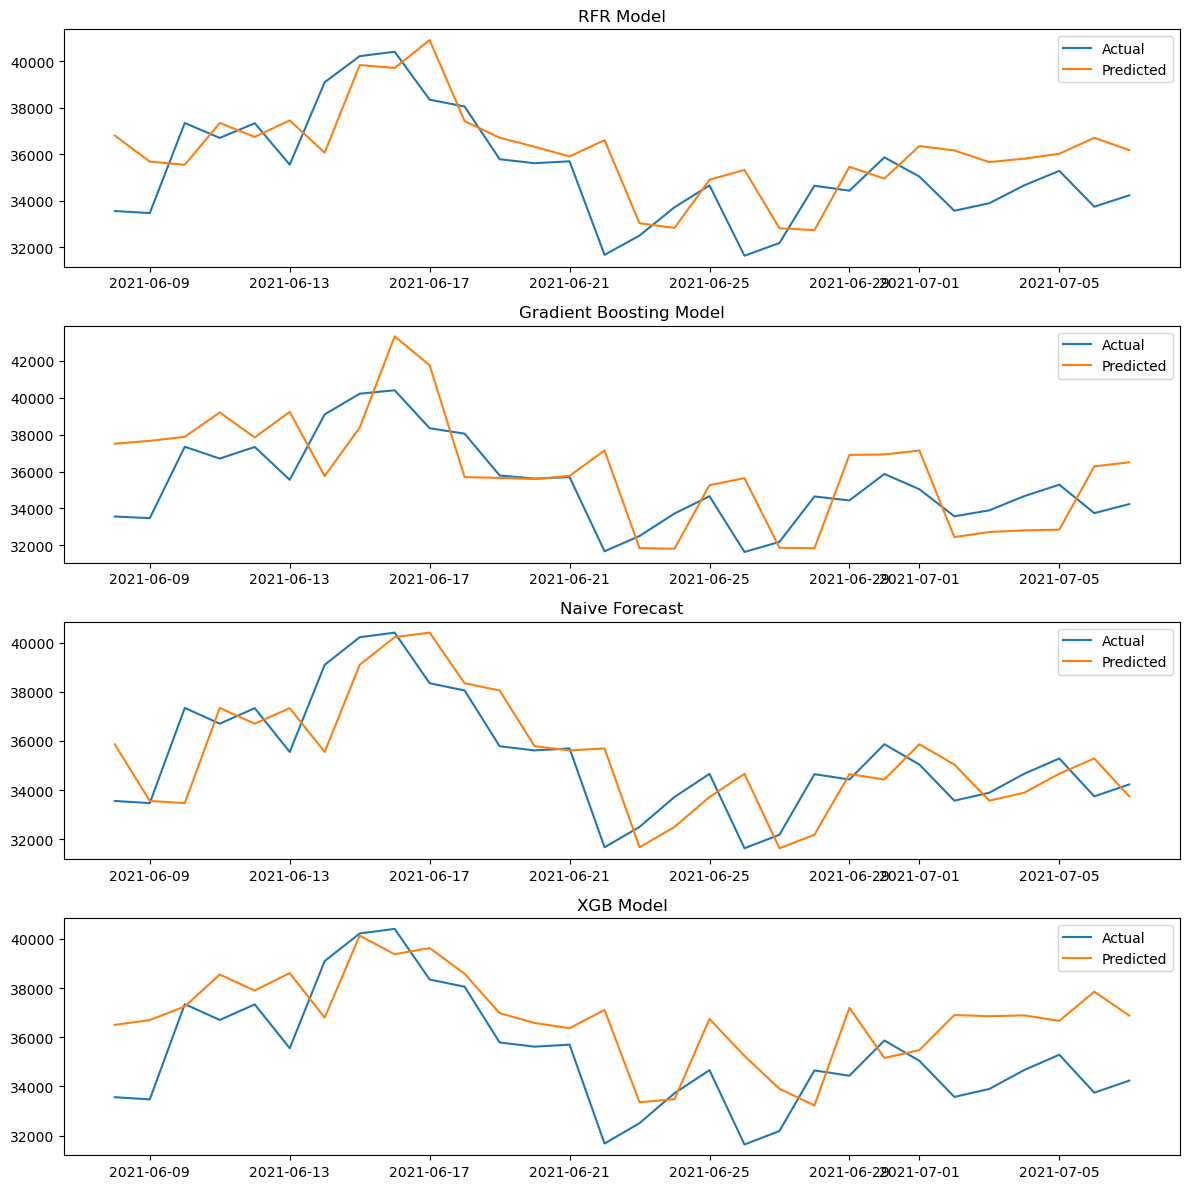

In [164]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, figsize=(12, 12))

axs[0].plot(test.index, test['Close'], label='Actual')
axs[0].plot(test.index, test_prediction_rfr, label='Predicted')
axs[0].set_title('RFR Model')
axs[0].legend()


axs[1].plot(test.index, test['Close'], label='Actual')
axs[1].plot(test.index, test_prediction_gb, label='Predicted')
axs[1].set_title('Gradient Boosting Model')
axs[1].legend()

axs[2].plot(test.index, test['Close'], label='Actual')
axs[2].plot(test.index, naive_forecast, label='Predicted')
axs[2].set_title('Naive Forecast')
axs[2].legend()

axs[3].plot(test.index, test['Close'], label='Actual')
axs[3].plot(test.index, test_prediction_xgb, label='Predicted')
axs[3].set_title('XGB Model')
axs[3].legend()

plt.tight_layout()

plt.show()

# Adding technical analysis features

Let's try a different approach - let's reduce the number of lagged features and include technical analysis metrics and see whether it improves the quality of the predictions.

In [314]:
from ta import add_all_ta_features

features = add_all_ta_features(bitcoin, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
features = features[['Close', 'volume_adi', 'volatility_bbm', 'trend_macd', 'momentum_rsi']]


features['lag_1'] = features['Close'].shift(1)
features['lag_2'] = features['Close'].shift(2)
features['lag_3'] = features['Close'].shift(3)
features['lag_7'] = features['Close'].shift(7)


features['day_of_week'] = features.index.dayofweek
features['month'] = features.index.month
features['year'] = features.index.year


features.dropna(inplace=True)

features.tail()

C:\Users\mwdzi\AppData\Local\Temp\ipykernel_15600\1432563257.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['lag_1'] = features['Close'].shift(1)
C:\Users\mwdzi\AppData\Local\Temp\ipykernel_15600\1432563257.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['lag_2'] = features['Close'].shift(2)
C:\Users\mwdzi\AppData\Local\Temp\ipykernel_15600\1432563257.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

,Close,volume_adi,volatility_bbm,trend_macd,momentum_rsi,lag_1,lag_2,lag_3,lag_7,day_of_week,month,year
Date,,,,,,,,,,,,
2021-07-02 23:59:59,33897.048590,3.973788e+12,35353.911146,-1179.730837,44.840772,33572.117653,35040.837249,35867.777735,31637.780055,4,7,2021
2021-07-03 23:59:59,34668.548402,3.990380e+12,35132.445521,-1071.555752,47.175200,33897.048590,33572.117653,35040.837249,32186.277671,5,7,2021
2021-07-04 23:59:59,35287.779766,3.994286e+12,34885.910617,-925.194358,49.039426,34668.548402,33897.048590,33572.117653,34649.644588,6,7,2021
2021-07-05 23:59:59,33746.002456,3.981304e+12,34552.897290,-922.971007,44.800134,35287.779766,34668.548402,33897.048590,34434.335314,0,7,2021
2021-07-06 23:59:59,34235.193451,3.978208e+12,34347.303801,-871.687094,46.383877,33746.002456,35287.779766,34668.548402,35867.777735,1,7,2021


In [315]:
train = features.iloc[:-forecast_length]
test = features.iloc[-forecast_length:]

X = train.drop('Close', axis=1)
y = train['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [316]:
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [20, 30, 40, None],
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
rf_model = grid_search.best_estimator_

print(best_params)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'max_depth': 20, 'n_estimators': 500}


In [317]:
param_grid = {
    'n_estimators': [400, 500, 600, 700],
    'max_depth': [20, 30, 40],
}

gb = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_percentage_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
gb_model = grid_search.best_estimator_

print(best_params)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'max_depth': 20, 'n_estimators': 400}


In [318]:
param_grid = {
    'n_estimators': [400, 500, 600, 700],
    'max_depth': [30, 40, 50],
    'learning_rate': [0.01, 0.1, 0.3]
}

xgb_model = XGBRegressor(random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_percentage_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
xgb_model = grid_search.best_estimator_

print(best_params)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 700}


In [322]:
print("Random Forest MAPE: ", mean_absolute_percentage_error(y_test, rf_model.predict(X_test))*100)
print("Gradient Boosting MAPE: ", mean_absolute_percentage_error(y_test, gb_model.predict(X_test))*100)
print("XGBoost MAPE: ", mean_absolute_percentage_error(y_test, xgb_model.predict(X_test))*100)

Random Forest MAPE:  2.2737582980181146
Gradient Boosting MAPE:  2.8679481823216464
XGBoost MAPE:  2.3423135843839527


In [324]:
test_prediction_rfr = make_predictions(rf_model)
test_prediction_gb = make_predictions(gb_model)
test_prediction_xgb = make_predictions(xgb_model)

print(f'Rfr MAPE: {mean_absolute_percentage_error(test["Close"], test_prediction_rfr)*100}')
print(f'GB MAPE: {mean_absolute_percentage_error(test["Close"], test_prediction_gb)*100}')
print(f'XGB MAPE: {mean_absolute_percentage_error(test["Close"], test_prediction_xgb)*100}')

naive_forecast = get_naive_forecast()
print(f'Naive MAPE: {mean_absolute_percentage_error(test["Close"], naive_forecast)*100}')

Rfr MAPE: 4.462462665435374
GB MAPE: 5.971066190119432
XGB MAPE: 4.228757184203423
Naive MAPE: 3.789446641682695


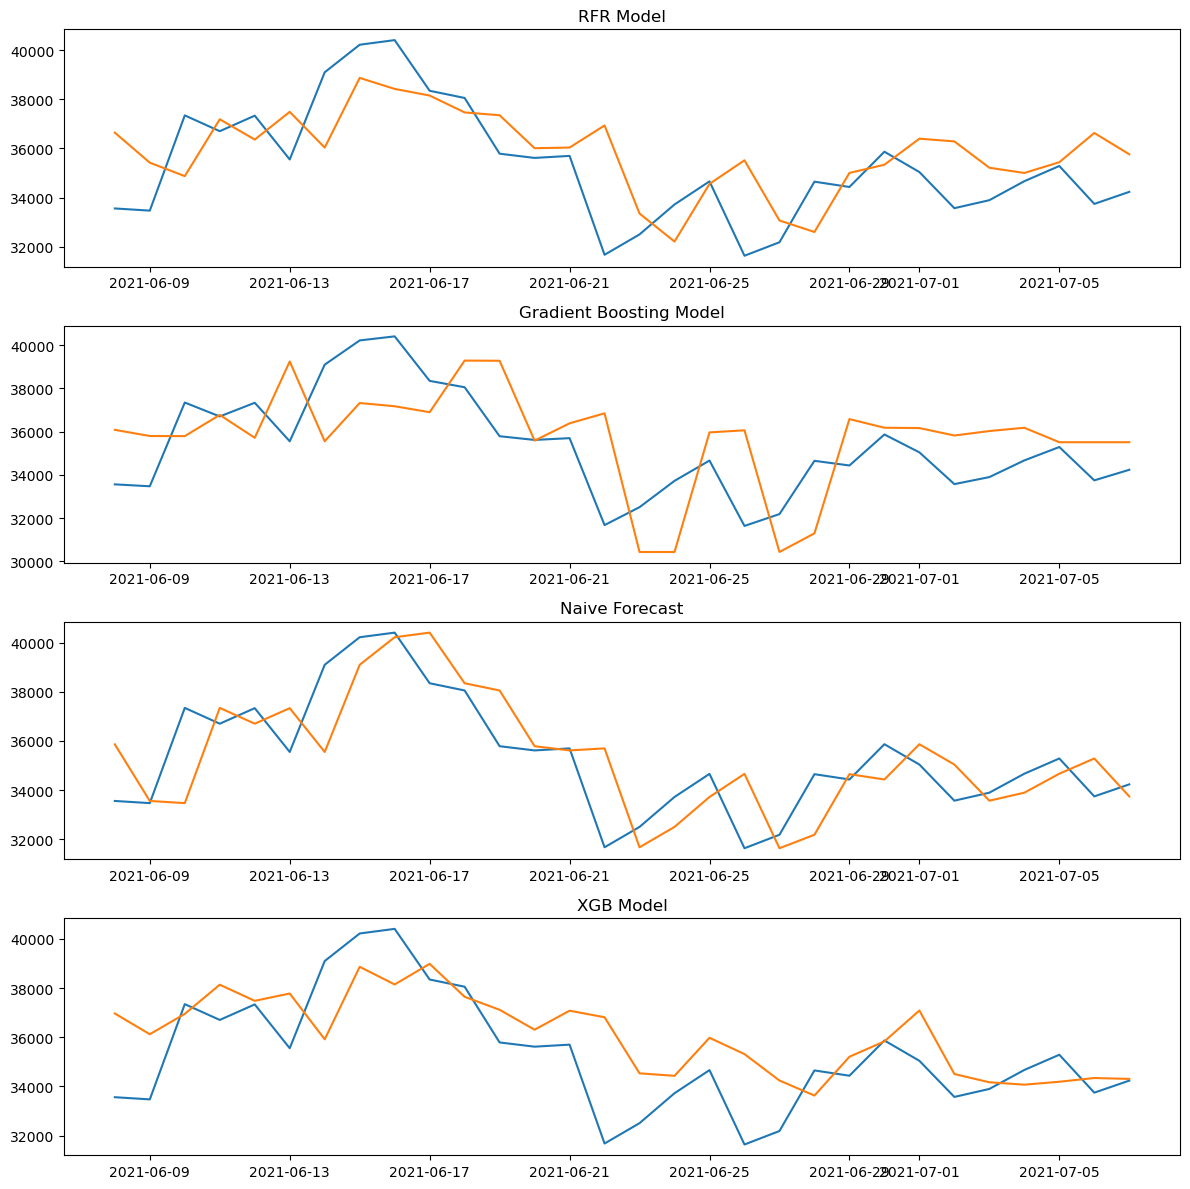

In [325]:
fig, axs = plt.subplots(4, figsize=(12, 12))

axs[0].plot(test.index, test['Close'], label='Actual')
axs[0].plot(test.index, test_prediction_rfr, label='Predicted')
axs[0].set_title('RFR Model')

axs[1].plot(test.index, test['Close'], label='Actual')
axs[1].plot(test.index, test_prediction_gb, label='Predicted')
axs[1].set_title('Gradient Boosting Model')

axs[2].plot(test.index, test['Close'], label='Actual')
axs[2].plot(test.index, naive_forecast, label='Predicted')
axs[2].set_title('Naive Forecast')

axs[3].plot(test.index, test['Close'], label='Actual')
axs[3].plot(test.index, test_prediction_xgb, label='Predicted')
axs[3].set_title('XGB Model')

plt.tight_layout()

plt.show()

The predictions improved significantly, but the naive forecast is still better.

# LSTM forecasting

Let's try training an LSTM model to see if it can do better.

In [290]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

training_data_len = len(scaled_features) - forecast_length - 1
train_data = scaled_features[0:training_data_len, :]
test_data = scaled_features[training_data_len - 60:, :]

def create_dataset(data, time_step=1):
    x, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step)]
        x.append(a)
        y.append(data[i + time_step, 0])
    return np.array(x), np.array(y)

time_step = 60
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

In [308]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, x_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\mwdzi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [309]:
model.fit(x_train, y_train, batch_size=32, epochs=30)

Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0062
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7.0446e-04
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.9001e-04
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.1527e-04
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.1515e-04
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.8752e-04
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.1762e-04
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.6158e-04
Epoch 9/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 3.8054e-04
Epoch 10/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 2.1291e-04
Epoch 11/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 1.9395e-04
Epoch 12/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.8986e-04
Epoch 13/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.6504e-04
Epoch 14/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 1.6886e-04
Epoch 15/30
91/91 ━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


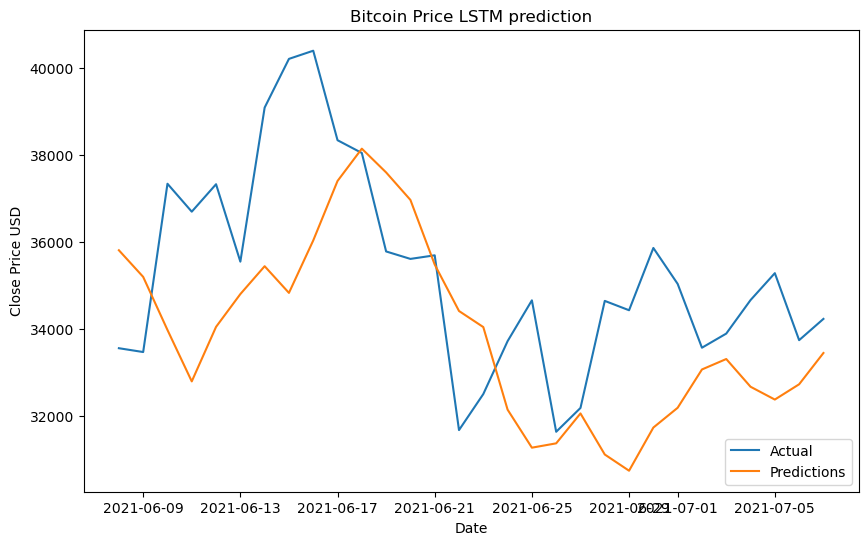

In [313]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], scaled_features.shape[1] - 1)))))[:, 0]

valid = features[training_data_len:]
valid = valid[-len(predictions):]
valid['Predictions'] = predictions

plt.figure(figsize=(10, 6))
plt.plot(valid[['Close', 'Predictions']])
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.title('Bitcoin Price LSTM prediction')
plt.legend(['Actual', 'Predictions'], loc='lower right')
plt.show()

In [311]:
print(f'MAPE: {mean_absolute_percentage_error(valid["Close"], valid["Predictions"])*100}')
print(f'Naive MAPE: {mean_absolute_percentage_error(valid["Close"], naive_forecast)*100}')

MAPE: 6.0108348835447485
Naive MAPE: 3.789446641682695


The LSTM performed significantly worse than the classical machine learning regressors.

# Conclusions

Cryptocurrency price forecasting is a very difficult task. Despite best efforts, none of the techniques applied in this notebook produced forecasts of good accuracy. The best predictions were made by the XGBoost model with technical analysis features and lags: 1, 2, 3, 7. In order to improve the predictions, other more complicated techniques should be implemented: like social media sentiment analysis, as cryptocurrency prices are highly susceptible to price variations cause by the changing sentiments often expressed at such platforms. 